# Convolutional neural networks for artistic style transfer

This iPython notebook is an implementation of a popular paper ([Gatys et al., 2015](https://arxiv.org/abs/1508.06576)) that demonstrates how to use neural networks to transfer artistic style from one image onto another.

<a name='2'></a>
## What is neural style transfer?

Neural Style Transfer (NST) is one of the most fun and interesting optimization techniques in deep learning. It merges two images, namely: a <strong>"content" image (C)</strong> and a <strong>"style" image (S)</strong>, to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S. It uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

You will use the eponymously named VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at University of Oxford in 2014. Specifically, you'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

Let's get started!

In [45]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf

In [46]:
from keras import backend
from scipy.optimize import fmin_l_bfgs_b

In [47]:
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [48]:
height = 512
width = 512
vgg = tf.keras.applications.VGG16(include_top=False,
                                  input_shape=(height, width, 3),
                                  weights='imagenet')

vgg.trainable = False


## Make Generated Image G Match the Content of Image C

One goal you should aim for when performing NST is for the content in generated image G to match the content of image C. To do so, you'll need an understanding of <b> shallow versus deep layers </b>:

* The shallower layers of a ConvNet tend to detect lower-level features such as <i>edges and simple textures</i>.
* The deeper layers tend to detect higher-level features such as more <i> complex textures and object classes</i>. 

### To choose a "middle" activation layer $a^{[l]}$ :
You need the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. 
* In practice, you will usually get the most visually pleasing results if you choose a layer from somewhere in the middle of the network--neither too shallow nor too deep. This ensures that the network detects both higher-level and lower-level features.
* After you have finished this exercise, feel free to come back and experiment with using different layers to see how the results vary!

### To forward propagate image "C:"
* Set the image C as the input to the pretrained VGG network, and run forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. (In lecture, this was written as $a^{[l](C)}$, but here the superscript $[l]$ is dropped to simplify the notation.) This will be an $n_H \times n_W \times n_C$ tensor.

### To forward propagate image "G":
* Repeat this process with the image G: Set G as the input, and run forward propagation. 
* Let $a^{(G)}$ be the corresponding hidden layer activation. 



In [49]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # Retrieve dimensions from a_G 
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape 'a_C' and 'a_G' 
    a_C_unrolled = tf.reshape(a_C, [n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, [n_H * n_W, n_C])
    
    # compute the cost with tensorflow 
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) # * 1 / (4 * n_H * n_W * n_C) * 
    
    
    return tf.convert_to_tensor(J_content)

## Style Matrix

### Gram matrix
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

### Two meanings of the variable $G$
* Note that there is an unfortunate collision in the variable names used here. Following the common terminology used in the literature: 
    * $G$ is used to denote the Style matrix (or Gram matrix) 
    * $G$ also denotes the generated image. 


In [50]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    GA = tf.linalg.matmul(A, tf.transpose(A))

    return tf.convert_to_tensor(GA)

## Style cost
You now know how to calculate the Gram matrix. Congrats! Your next goal will be to minimize the distance between the Gram matrix of the "style" image S and the Gram matrix of the "generated" image G. 
* For now, you will use only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Make sure you remember that this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$

In [51]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    # Retrieve dimensions from a_G 
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W) 
    a_S = tf.transpose(tf.reshape(a_S, [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss 
    J_style_layer = 1 / (4 * (n_H * n_W * n_C)**2) * tf.reduce_sum(tf.square(GS - GG))
    
    return tf.convert_to_tensor(J_style_layer)

In [52]:
STYLE_LAYERS = [
    ('block1_conv2', 1.0),
    ('block2_conv2', 1.0),
    ('block3_conv3', 1.0),
    ('block4_conv3', 1.0),
    ('block5_conv3', 1.0)]

In [53]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return tf.convert_to_tensor(J_style)

## The total variation loss

Now we're back on simpler ground.

If you were to solve the optimisation problem with only the two loss terms we've introduced so far (style and content), you'll find that the output is quite noisy. We thus add another term, called the [total variation loss](http://arxiv.org/abs/1412.0035) (a regularisation term) that encourages spatial smoothness.

You can experiment with reducing the `total_variation_weight` and play with the noise-level of the generated image.

In [54]:
def compute_variation_loss(generated_image):
    a = tf.square(generated_image[:, :height-1, :width-1, :] - generated_image[:, 1:, :width-1, :])
    b = tf.square(generated_image[:, :height-1, :width-1, :] - generated_image[:, :height-1, 1:, :])
    J_variation = tf.reduce_sum(tf.pow(a + b, 1.25))
    return tf.convert_to_tensor(J_variation)

In [55]:
content_weight = 0.025
style_weight = 1.0
total_variation_weight = 1.0

In [56]:
#@tf.function()
def total_cost(J_content, J_style, J_variation,  content_weight = 0.025, style_weight = 1.0, total_variation_weight = 1):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J_content = tf.cast(J_content, tf.float64)
    J_style = tf.cast(J_style, tf.float64)
    J_variation = tf.cast(J_variation, tf.float64)
    content_weight = tf.cast(content_weight, tf.float64)
    style_weight = tf.cast(style_weight, tf.float64)
    total_variation_weight = tf.cast(total_variation_weight, tf.float64)
    
    J = J_content * content_weight + J_style * style_weight + J_variation * total_variation_weight
    J = J_content * content_weight + J_style * style_weight + J_variation * total_variation_weight
    

    return tf.convert_to_tensor(J)

Below the content image and style image we want to use for style transfer

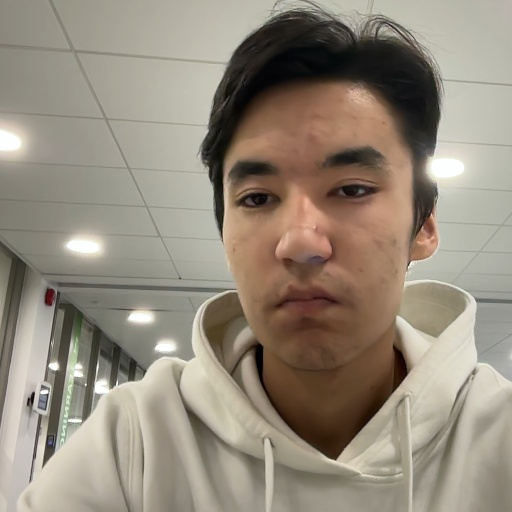

In [57]:
content_image_path = 'images/content/84f14fbe-b675-11ee-951f-1e592a5e1492.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

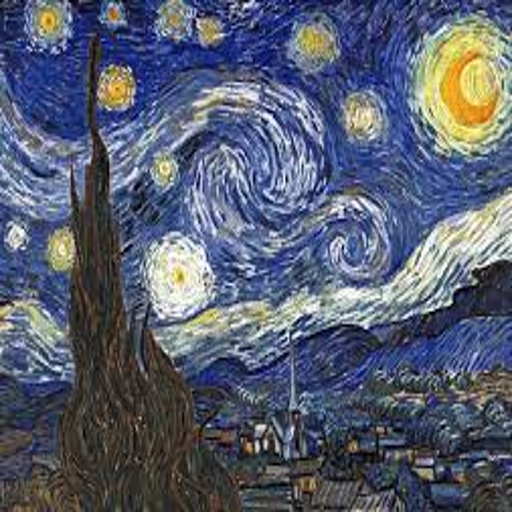

In [58]:
style_image_path = 'images/style/vangogh.jpeg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

In [59]:
content_array = np.array(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.array(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


Before we proceed much further, we need to massage this input data to match what was done in [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), the paper that introduces the *VGG Network* model that we're going to use shortly.

For this, we need to perform two transformations:

1. Subtract the mean RGB value (computed previously on the [ImageNet training set](http://image-net.org) and easily obtainable from Google searches) from each pixel.
2. Flip the ordering of the multi-dimensional array from *RGB* to *BGR* (the ordering used in the paper).

In [60]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [61]:
np.max(content_array)

151.061

In [62]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [63]:
content_layer = [('block2_conv2', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [64]:
vgg_model_outputs.trainable = False

In [65]:
content_target = vgg_model_outputs(content_array)  # Content encoder
style_targets = vgg_model_outputs(style_array)     # Style encoder

In [66]:
content_target[0].shape

TensorShape([1, 512, 512, 64])

In [67]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(content_array)
a_C = vgg_model_outputs(preprocessed_content)

In [68]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(style_array)
a_S = vgg_model_outputs(preprocessed_style)

In [69]:
a_S[0].shape

TensorShape([1, 512, 512, 64])

In [70]:
# Define the cost function
def cost_function(generated_image):
    with tf.GradientTape() as tape:
        generated_image = tf.reshape(generated_image, (1, height, width, 3))
        a_G = vgg_model_outputs(generated_image) 
        J_style = compute_style_cost(a_S, a_G, STYLE_LAYERS=STYLE_LAYERS)
        J_variation = compute_variation_loss(generated_image)
        J_content = compute_content_cost(a_C, a_G)
        J = total_cost(J_content, J_style, J_variation,  content_weight = 0.025, style_weight = 5, total_variation_weight = 1)
    return J

In [71]:
@tf.function()
def gradient_function(generated_image):
    generated_image = tf.convert_to_tensor(generated_image)
    with tf.GradientTape() as tape:
        tape.watch(generated_image)
        generated_image = tf.reshape(generated_image, (1, height, width, 3))
        a_G = vgg_model_outputs(generated_image) 
        J_style = compute_style_cost(a_S, a_G, STYLE_LAYERS=STYLE_LAYERS)
        J_variation = compute_variation_loss(generated_image)
        J_content = compute_content_cost(a_C, a_G)
        J = total_cost(J_content, J_style, J_variation, content_weight=0.025, style_weight=50, total_variation_weight=1)
    grad = tape.gradient(J, generated_image)
    return tf.reshape(grad, [-1])


In [72]:
# Define a function to print the cost after each epoch
def print_cost(epoch, cost):
    print(f"Epoch: {epoch}, Cost: {cost}")

Lets define x, a randomly distributed noisy image. It will be initial input image  to our model

In [73]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

Now we're finally ready to solve our optimisation problem. This combination image begins its life as a random collection of (valid) pixels, and we use the [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon it.

We stop after 10 iterations because the output looks good to me and the loss stops reducing significantly.

In [74]:
pre_cost = 0
for epoch in range(10):
    x, cost, _ = fmin_l_bfgs_b(cost_function, x, fprime=gradient_function, maxfun = 20)
    print_cost(epoch, cost)

2024-03-14 15:58:58.150372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch: 0, Cost: 32221629461.988674
Epoch: 1, Cost: 22467523224.134556
Epoch: 2, Cost: 20713407805.404366
Epoch: 3, Cost: 20713407805.404366
Epoch: 4, Cost: 20713407805.40437
Epoch: 5, Cost: 20713407805.40437
Epoch: 6, Cost: 20713407805.40437
Epoch: 7, Cost: 20713407805.40437
Epoch: 8, Cost: 20713407805.40437
Epoch: 9, Cost: 20713407805.40437


In [75]:
optimized_generated_image = tf.reshape(x, (height, width, 3))

In [76]:
optimized_array = optimized_generated_image.numpy()

Notice that we need to subject our output image to the inverse of the transformation we did to our input images before it makes sense.

In [77]:
optimized_array = optimized_array[:, :, ::-1]
optimized_array[:, :, 0] += 103.939
optimized_array[:, :, 1] += 116.779
optimized_array[:, :, 2] += 123.68
optimized_array = np.clip(optimized_array, 0, 255).astype('uint8')

In [78]:
optimized_array.shape

(512, 512, 3)

Below, we get the  generated image (content + style)

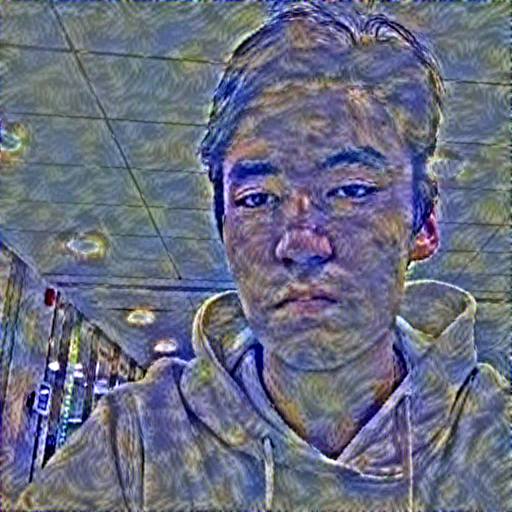

In [79]:
Image.fromarray(optimized_array)

That's how Neural Style Transfer works. Now you can generate any artistic image. To facilitate process, below you can find function called artist: all the codes in one function

In [37]:
def artist(content_path, style_path, vgg_model, height = 512, width = 512):
    
    def compute_content_cost(content_output, generated_output):
        """
        Computes the content cost

        Arguments:
        a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
        a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

        Returns: 
        J_content -- scalar that you compute using equation 1 above.
        """
        a_C = content_output[-1]
        a_G = generated_output[-1]


        # Retrieve dimensions from a_G (≈1 line)
        _, n_H, n_W, n_C = a_G.get_shape().as_list()

        # Reshape 'a_C' and 'a_G' (≈2 lines)
        # DO NOT reshape 'content_output' or 'generated_output'
        a_C_unrolled = tf.reshape(a_C, [n_H * n_W, n_C])
        a_G_unrolled = tf.reshape(a_G, [n_H * n_W, n_C])

        # compute the cost with tensorflow (≈1 line)
        J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) # * 1 / (4 * n_H * n_W * n_C) * 

        return tf.convert_to_tensor(J_content)

    def compute_variation_loss(generated_image):
        a = tf.square(generated_image[:, :height-1, :width-1, :] - generated_image[:, 1:, :width-1, :])
        b = tf.square(generated_image[:, :height-1, :width-1, :] - generated_image[:, :height-1, 1:, :])
        J_variation = tf.reduce_sum(tf.pow(a + b, 1.25))
        return tf.convert_to_tensor(J_variation)
    
    def gram_matrix(A):
        """
        Argument:
        A -- matrix of shape (n_C, n_H*n_W)

        Returns:
        GA -- Gram matrix of A, of shape (n_C, n_C)
        """  
        GA = tf.linalg.matmul(A, tf.transpose(A))

        return tf.convert_to_tensor(GA)
    
    def compute_layer_style_cost(a_S, a_G):
        """
        Arguments:
        a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
        a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

        Returns: 
        J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
        """
        # Retrieve dimensions from a_G (≈1 line)
        _, n_H, n_W, n_C = a_G.get_shape().as_list()

        # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W) (≈2 lines)
        a_S = tf.transpose(tf.reshape(a_S, [n_H * n_W, n_C]))
        a_G = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))

        # Computing gram_matrices for both images S and G (≈2 lines)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)

        # Computing the loss (≈1 line)
        J_style_layer = 1 / (4 * (n_H * n_W * n_C)**2) * tf.reduce_sum(tf.square(GS - GG))

        return tf.convert_to_tensor(J_style_layer)
    
    STYLE_LAYERS = [
    ('block1_conv2', 1.0),
    ('block2_conv2', 1.0),
    ('block3_conv3', 1.0),
    ('block4_conv3', 1.0),
    ('block5_conv3', 1.0)]
    
    def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
        """
        Computes the overall style cost from several chosen layers

        Arguments:
        style_image_output -- our tensorflow model
        generated_image_output --
        STYLE_LAYERS -- A python list containing:
                            - the names of the layers we would like to extract style from
                            - a coefficient for each of them

        Returns: 
        J_style -- tensor representing a scalar value, style cost defined above by equation (2)
        """

        # initialize the overall style cost
        J_style = 0

        # Set a_S to be the hidden layer activation from the layer we have selected.
        # The last element of the array contains the content layer image, which must not be used.
        a_S = style_image_output[:-1]

        # Set a_G to be the output of the choosen hidden layers.
        # The last element of the list contains the content layer image which must not be used.
        a_G = generated_image_output[:-1]
        for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
            # Compute style_cost for the current layer
            J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

            # Add weight * J_style_layer of this layer to overall style cost
            J_style += weight[1] * J_style_layer

        return tf.convert_to_tensor(J_style)
    
    def total_cost(J_content, J_style, J_variation,  content_weight = 0.025, style_weight = 1.0, total_variation_weight = 1):
        """
        Computes the total cost function

        Arguments:
        J_content -- content cost coded above
        J_style -- style cost coded above
        alpha -- hyperparameter weighting the importance of the content cost
        beta -- hyperparameter weighting the importance of the style cost

        Returns:
        J -- total cost as defined by the formula above.
        """

        #(≈1 line)
        J_content = tf.cast(J_content, tf.float64)
        J_style = tf.cast(J_style, tf.float64)
        J_variation = tf.cast(J_variation, tf.float64)
        content_weight = tf.cast(content_weight, tf.float64)
        style_weight = tf.cast(style_weight, tf.float64)
        total_variation_weight = tf.cast(total_variation_weight, tf.float64)

        J = J_content * content_weight + J_style * style_weight + J_variation * total_variation_weight
        J = J_content * content_weight + J_style * style_weight + J_variation * total_variation_weight

        return tf.convert_to_tensor(J)
    
    content_image = Image.open(content_path)
    #content_image = content_image.resize((height, width))
    
    style_image = Image.open(style_path)
    style_image = style_image.resize((width, height))
    
    content_array = np.array(content_image, dtype='float32')
    content_array = np.expand_dims(content_array, axis=0)
    
    style_array = np.array(style_image, dtype='float32')
    style_array = np.expand_dims(style_array, axis=0)
    
    content_array[:, :, :, 0] -= 103.939
    content_array[:, :, :, 1] -= 116.779
    content_array[:, :, :, 2] -= 123.68
    content_array = content_array[:, :, :, ::-1]

    style_array[:, :, :, 0] -= 103.939
    style_array[:, :, :, 1] -= 116.779
    style_array[:, :, :, 2] -= 123.68
    style_array = style_array[:, :, :, ::-1]
    
    def get_layer_outputs(vgg, layer_names):
        """ Creates a vgg model that returns a list of intermediate output values."""
        outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

        model = tf.keras.Model([vgg.input], outputs)
        return model
    
    content_layer = [('block2_conv2', 1)]

    vgg_model_outputs = get_layer_outputs(vgg_model, STYLE_LAYERS + content_layer)
    
    vgg_model_outputs.trainable = False
    
    # Assign the content image to be the input of the VGG model.  
    # Set a_C to be the hidden layer activation from the layer we have selected
    preprocessed_content =  tf.Variable(content_array)
    a_C = vgg_model_outputs(preprocessed_content)
    
    # Assign the input of the model to be the "style" image 
    preprocessed_style =  tf.Variable(style_array)
    a_S = vgg_model_outputs(preprocessed_style)
    
    # Define the cost function
    def cost_function(generated_image):
        with tf.GradientTape() as tape:
            generated_image = tf.reshape(generated_image, (1, height, width, 3))
            a_G = vgg_model_outputs(generated_image) 
            J_style = compute_style_cost(a_S, a_G, STYLE_LAYERS=STYLE_LAYERS)
            J_variation = compute_variation_loss(generated_image)
            J_content = compute_content_cost(a_C, a_G)
            J = total_cost(J_content, J_style, J_variation,  content_weight = 0.025, style_weight = 5, total_variation_weight = 1)
        return J
    
    @tf.function()
    def gradient_function(generated_image):
        generated_image = tf.convert_to_tensor(generated_image)
        with tf.GradientTape() as tape:
            tape.watch(generated_image)
            generated_image = tf.reshape(generated_image, (1, height, width, 3))
            a_G = vgg_model_outputs(generated_image) 
            J_style = compute_style_cost(a_S, a_G, STYLE_LAYERS=STYLE_LAYERS)
            J_variation = compute_variation_loss(generated_image)
            J_content = compute_content_cost(a_C, a_G)
            J = total_cost(J_content, J_style, J_variation, content_weight=0.025, style_weight=50, total_variation_weight=1)
        grad = tape.gradient(J, generated_image)
        return tf.reshape(grad, [-1])
    
    # Define a function to print the cost after each epoch
    def print_cost(epoch, cost):
        print(f"Epoch: {epoch}, Cost: {cost}")
    
    x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.
    
    for epoch in range(10):
        x, cost, _ = fmin_l_bfgs_b(cost_function, x, fprime=gradient_function, maxfun = 20)
        print_cost(epoch, cost)
        
    optimized_generated_image = tf.reshape(x, (height, width, 3))
    optimized_array = optimized_generated_image.numpy()
    
    optimized_array = optimized_array[:, :, ::-1]
    optimized_array[:, :, 0] += 103.939
    optimized_array[:, :, 1] += 116.779
    optimized_array[:, :, 2] += 123.68
    optimized_array = np.clip(optimized_array, 0, 255).astype('uint8')
    
    return optimized_array

In [80]:
style_path = 'images/style/Tsunami_by_hokusai_19th_century.jpg'

In [81]:
content_path = 'images/content/bekarys_omirzakov.jpg'

In [82]:
np.array(Image.open(content_path)).shape

(1024, 768, 3)

In [83]:
vgg = tf.keras.applications.VGG16(include_top=False,
                                  input_shape=(1024, 768, 3),
                                  weights='imagenet')

vgg.trainable = False

In [84]:
style_transfer = artist(content_path, style_path, vgg, height = 1024, width = 768)

Epoch: 0, Cost: 65576199227.68613
Epoch: 1, Cost: 58377572289.931725


In [ ]:
Image.fromarray(style_transfer)